In [1]:
# Generate demo CSV if not exists
import os
import pandas as pd

csv_path = 'data/instructor_dirty.csv'
os.makedirs('data', exist_ok=True)

#creating the data set if there are not exist in my folder
if not os.path.exists(csv_path):
    df_demo = pd.DataFrame({
        'numeric_col': [10, None, 40, 55, 70],
        'category_col': ['A', 'B', 'A', 'B', 'C'],
        'price': ['$100', '$200', '$150', None, '$250'],
        'date_str': ['2025-08-01','2025-08-02',None,'2025-08-04','2025-08-05'],
        'category': ['Electronics','Furniture','Toys','Clothing',None]
    })
    df_demo.to_csv(csv_path, index=False)
    print(f"Demo CSV created at {csv_path}")
else:
    print(f"CSV already exists at {csv_path}")

CSV already exists at data/instructor_dirty.csv


# Stage 6: Comprehensive Data Preprocessing
- Missing data handling (MCAR/MAR/MNAR, visualization, fill/drop strategies)
- Filtering and threshold-based row drops
- Type corrections (currency, dates, categorical)
- Scaling/normalization (MinMax, StandardScaler)
- Reusable functions for reproducibility and workflow


In [2]:
# Imports
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing and Scaling for data clean up
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import missingno as msno

## Load Dataset

In [3]:
# Load instructor CSV
df = pd.read_csv('data/instructor_dirty.csv')
df.head()

,numeric_col,category_col,price,date_str,category
0,10.0,A,$100,2025-08-01,Electronics
1,NaN,B,$200,2025-08-02,Furniture
2,40.0,A,$150,NaN,Toys
3,55.0,B,NaN,2025-08-04,Clothing
4,70.0,C,$250,2025-08-05,NaN


## Inspect Missingness

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   numeric_col   4 non-null      float64
 1   category_col  5 non-null      object 
 2   price         4 non-null      object 
 3   date_str      4 non-null      object 
 4   category      4 non-null      object 
dtypes: float64(1), object(4)
memory usage: 332.0+ bytes


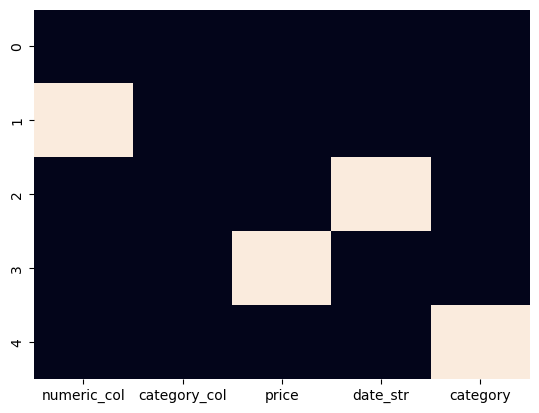

<Axes: >

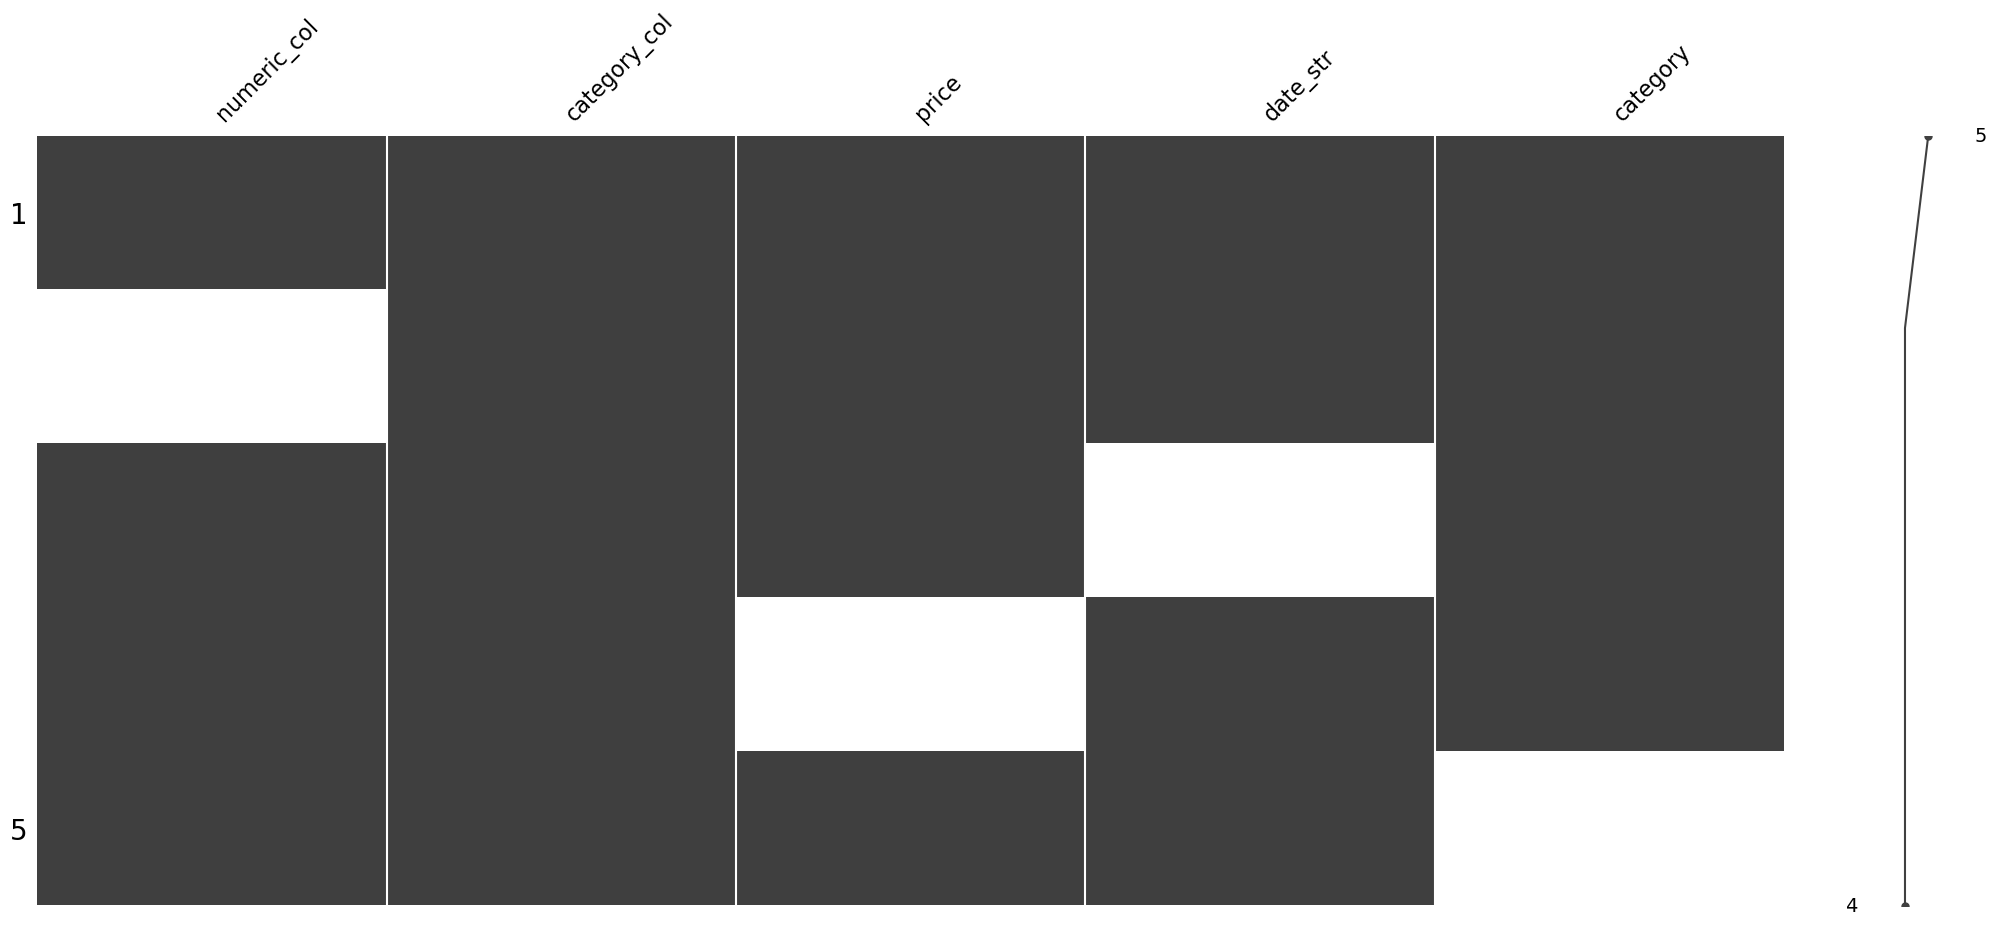

In [4]:
# Basic info and missing counts
df.info()
#isna give us missing data column
df.isna().sum()

# Heatmap for missing data
sns.heatmap(df.isnull(), cbar=False)
plt.show()

# missingno visualization
msno.matrix(df)

In [5]:
df['numeric_col']
df.shape[0], df.shape[1]

#create df2 and if above 0.1 then true; but if below 0.1 then false (isinya random)
r = np.random.rand(len(df)) 
df2 = df[['numeric_col']].copy()
df2['r'] = r 
df2['r_true'] = r>.1
print(df2)


   numeric_col         r  r_true
0         10.0  0.465048    True
1          NaN  0.329732    True
2         40.0  0.767582    True
3         55.0  0.441109    True
4         70.0  0.502187    True


In [6]:

#masking
mask = r<.5
df2['numeric_col'][mask]
print (df2)

   numeric_col         r  r_true
0         10.0  0.465048    True
1          NaN  0.329732    True
2         40.0  0.767582    True
3         55.0  0.441109    True
4         70.0  0.502187    True


## Simulate MCAR / MAR / MNAR Missingness

In [7]:
# MCAR: random missing (missing at random)
#anything less than 0.1 is true
df['MCAR_col'] = df['numeric_col'].mask(np.random.rand(len(df)) < 0.1)

# MAR: missing depends on another column 
df['MAR_col'] = df['numeric_col'].mask(df['category_col']=='A')

# MNAR: missing depends on its own value (missing not at random)
df['MNAR_col'] = df['numeric_col'].mask(df['numeric_col']>50)

In [8]:
df

,numeric_col,category_col,price,date_str,category,MCAR_col,MAR_col,MNAR_col
0,10.0,A,$100,2025-08-01,Electronics,NaN,NaN,10.0
1,NaN,B,$200,2025-08-02,Furniture,NaN,NaN,NaN
2,40.0,A,$150,NaN,Toys,40.0,NaN,40.0
3,55.0,B,NaN,2025-08-04,Clothing,55.0,55.0,NaN
4,70.0,C,$250,2025-08-05,NaN,70.0,70.0,NaN


In [18]:
#filter true or false sesuai kategori nya
(df["numeric_col"]>50) & (df["numeric_col"]<90)

0    False
1    False
2    False
3     True
4     True
Name: numeric_col, dtype: bool

## Handling Missing Values

In [26]:
# Fill missing with median
df['numeric_col'] = df['numeric_col'].fillna(df['numeric_col'].median())

#backward fill akan replace segaprokan data
# df.fillna(method='bfill')

# Drop rows with missing MCAR
# df.dropna(subset=['MCAR_col'], inplace=True)
df

# Alternative strategies
# df_fill_mean = df.fillna(df.mean(numeric_only=True))
# df_fill_median = df.fillna(df.median(numeric_only=True))
# df_fill_ffill = df.fillna(method='ffill') #forward fill (ikut data terdekat yg ada)

# Threshold-based row drop example
# df_drop_thresh = df.dropna(thresh=int(0.5*df.shape[1]))

,numeric_col,category_col,price,date_str,category,MCAR_col,MAR_col,MNAR_col,date,numeric_scaled,numeric_standard
0,10.0,A,100.0,2025-08-01,electronics,NaN,NaN,10.0,2025-08-01,0.000,-1.733690
1,47.5,B,200.0,2025-08-02,furniture,NaN,NaN,NaN,2025-08-02,0.625,0.150756
2,40.0,A,150.0,NaN,toys,40.0,NaN,40.0,NaT,0.500,-0.226134
3,55.0,B,NaN,2025-08-04,clothing,55.0,55.0,NaN,2025-08-04,0.750,0.527645
4,70.0,C,250.0,2025-08-05,NaN,70.0,70.0,NaN,2025-08-05,1.000,1.281423


In [34]:
#print data yg sudah hasil di drop kalau numeric_col nya kosong
df

,numeric_col,category_col,price,date_str,category,MCAR_col,MAR_col,MNAR_col,date,numeric_scaled,numeric_standard
0,10.0,A,100.0,2025-08-01,electronics,NaN,NaN,10.0,2025-08-01,0.000,-1.733690
1,47.5,B,200.0,2025-08-02,furniture,NaN,NaN,NaN,2025-08-02,0.625,0.150756
2,40.0,A,150.0,NaN,toys,40.0,NaN,40.0,NaT,0.500,-0.226134
3,55.0,B,NaN,2025-08-04,clothing,55.0,55.0,NaN,2025-08-04,0.750,0.527645
4,70.0,C,250.0,2025-08-05,NaN,70.0,70.0,NaN,2025-08-05,1.000,1.281423


In [38]:
df.dropna(thresh=7)  # Drop rows with less than 7 non-NA values

,numeric_col,category_col,price,date_str,category,MCAR_col,MAR_col,MNAR_col,date,numeric_scaled,numeric_standard
0,10.0,A,100.0,2025-08-01,electronics,NaN,NaN,10.0,2025-08-01,0.000,-1.733690
1,47.5,B,200.0,2025-08-02,furniture,NaN,NaN,NaN,2025-08-02,0.625,0.150756
2,40.0,A,150.0,NaN,toys,40.0,NaN,40.0,NaT,0.500,-0.226134
3,55.0,B,NaN,2025-08-04,clothing,55.0,55.0,NaN,2025-08-04,0.750,0.527645
4,70.0,C,250.0,2025-08-05,NaN,70.0,70.0,NaN,2025-08-05,1.000,1.281423


In [39]:
df.iloc[0,0] = np.nan

## Filtering Examples

In [49]:
#create df_filtered which price column is a float
# Make a copy
df_float = df.copy()

# Create a numeric column alongside the "$" price
df_float["price_float"] = (
    df_float["price"]
    .astype(str)                         # ensure string
    # .str.replace("$", "", regex=False)   # strip "$"
    .astype(float)                       # convert to float
)

print(df_float.head())
print(df_float.dtypes)

   numeric_col category_col  price    date_str     category  MCAR_col  \
0          NaN            A  100.0  2025-08-01  electronics       NaN   
1         47.5            B  200.0  2025-08-02    furniture       NaN   
2         40.0            A  150.0         NaN         toys      40.0   
3         55.0            B    NaN  2025-08-04     clothing      55.0   
4         70.0            C  250.0  2025-08-05          NaN      70.0   

   MAR_col  MNAR_col       date  numeric_scaled  numeric_standard  price_float  
0      NaN      10.0 2025-08-01           0.000         -1.733690        100.0  
1      NaN       NaN 2025-08-02           0.625          0.150756        200.0  
2      NaN      40.0        NaT           0.500         -0.226134        150.0  
3     55.0       NaN 2025-08-04           0.750          0.527645          NaN  
4     70.0       NaN 2025-08-05           1.000          1.281423        250.0  
numeric_col                float64
category_col                object
price

In [55]:
mask = df_float['price_float'] > 0
df_filtered = df_float[mask]

df_filtered

,numeric_col,category_col,price,date_str,category,MCAR_col,MAR_col,MNAR_col,date,numeric_scaled,numeric_standard,price_float
0,NaN,A,100.0,2025-08-01,electronics,NaN,NaN,10.0,2025-08-01,0.000,-1.733690,100.0
1,47.5,B,200.0,2025-08-02,furniture,NaN,NaN,NaN,2025-08-02,0.625,0.150756,200.0
2,40.0,A,150.0,NaN,toys,40.0,NaN,40.0,NaT,0.500,-0.226134,150.0
4,70.0,C,250.0,2025-08-05,NaN,70.0,70.0,NaN,2025-08-05,1.000,1.281423,250.0


## Type Corrections

In [61]:
# Currency string to numeric
#if 'price' in df.columns:
    #df['price'] = df['price'].str.replace('$','').astype(float)

# Convert string to datetime
if 'date_str' in df.columns:
    df['date'] = pd.to_datetime(df['date_str'], errors='coerce')

# Standardize categorical column
if 'category' in df.columns:
    df['category'] = df['category'].str.lower().astype('category')

df

,numeric_col,category_col,price,date_str,category,MCAR_col,MAR_col,MNAR_col,date,numeric_scaled,numeric_standard
0,NaN,A,100.0,2025-08-01,electronics,NaN,NaN,10.0,2025-08-01,0.000,-1.733690
1,47.5,B,200.0,2025-08-02,furniture,NaN,NaN,NaN,2025-08-02,0.625,0.150756
2,40.0,A,150.0,NaN,toys,40.0,NaN,40.0,NaT,0.500,-0.226134
3,55.0,B,NaN,2025-08-04,clothing,55.0,55.0,NaN,2025-08-04,0.750,0.527645
4,70.0,C,250.0,2025-08-05,NaN,70.0,70.0,NaN,2025-08-05,1.000,1.281423


In [ ]:
type(df['date'][3])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
#check ada category apa saja
df['category']

0    electronics
1      furniture
2           toys
3       clothing
4            NaN
Name: category, dtype: category
Categories (4, object): ['clothing', 'electronics', 'furniture', 'toys']

In [67]:
# ---- Column Type Demo ----
# import pandas as pd
# import numpy as np

# Demo DataFrame for column types
df_types_demo = pd.DataFrame({
    'all_integers': [1, 2, 3, 4],
    'integers_with_nan': [1, 2, np.nan, 4],
    'text_column': ['a', 'b', 'c', 'd'],
    'mixed_column': [1, 'two', 3, 4]
})

print("Demo DataFrame:")
print(df_types_demo)

# Show column types
print("\nColumn types:")
print(df_types_demo.dtypes)

# Convert 'integers_with_nan' to nullable Int64
df_types_demo['integers_with_nan'] = df_types_demo['integers_with_nan'].astype('Int64')
print("\nAfter converting 'integers_with_nan' to Int64:")
print(df_types_demo.dtypes)

# Select numeric columns (generic)
numeric_cols = df_types_demo.select_dtypes(include='number').columns
print("\nNumeric columns (generic):", list(numeric_cols))

# Select object columns (generic)
object_cols = df_types_demo.select_dtypes(include='object').columns
print("Object columns (generic):", list(object_cols))


Demo DataFrame:
   all_integers  integers_with_nan text_column mixed_column
0             1                1.0           a            1
1             2                2.0           b          two
2             3                NaN           c            3
3             4                4.0           d            4

Column types:
all_integers           int64
integers_with_nan    float64
text_column           object
mixed_column          object
dtype: object

After converting 'integers_with_nan' to Int64:
all_integers          int64
integers_with_nan     Int64
text_column          object
mixed_column         object
dtype: object

Numeric columns (generic): ['all_integers', 'integers_with_nan']
Object columns (generic): ['text_column', 'mixed_column']


## Scaling and Normalization

In [15]:
# MinMax scaling for numeric_col
scaler = MinMaxScaler()
df['numeric_scaled'] = scaler.fit_transform(df[['numeric_col']])

# StandardScaler
standardizer = StandardScaler()
df['numeric_standard'] = standardizer.fit_transform(df[['numeric_col']])

## Reusable Functions for Cleaning

In [90]:
#filling data dengan asumsi median
def fill_missing_median(df, columns=None):
    df_copy = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns
    for col in columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    return df_copy

#hapus data, risiko nya data hilang
def drop_missing(df, columns=None, threshold=None):
    df_copy = df.copy()
    if columns is not None:
        return df_copy.dropna(subset=columns)
    if threshold is not None:
        return df_copy.dropna(thresh=int(threshold*df_copy.shape[1]))
    return df_copy.dropna()

def normalize_data(df, columns=None, method='minmax'):
    df_copy = df.copy()
    if columns is None:
        columns = df_copy.select_dtypes(include=np.number).columns
    if method=='minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    df_copy[columns] = scaler.fit_transform(df_copy[columns])
    return df_copy

# def correct_column_types(df):
#     df_copy = df.copy()
#     #if 'price' in df_copy.columns:
#         #df_copy['price'] = df_copy['price'].str.replace('$','').astype(float)
#     if 'date_str' in df_copy.columns:
#         df_copy['date'] = pd.to_datetime(df_copy['date_str'], errors='coerce')
#     if 'category' in df_copy.columns:
#         df_copy['category'] = df_copy['category'].str.lower().astype('category')
#     return df_copy

def correct_column_types(df):
    df_copy = df.copy()

    # Fix dates
    if 'date_str' in df_copy.columns:
        df_copy['date'] = pd.to_datetime(df_copy['date_str'], errors='coerce')
        df_copy['date'] = df_copy['date'].fillna(method='ffill')  # fill forward
        # if still NaN at start, fallback to earliest valid date
        if df_copy['date'].isna().any():
            min_date = df_copy['date'].dropna().min()
            df_copy['date'] = df_copy['date'].fillna(min_date)

    # Fix categories
    if 'category' in df_copy.columns:
        df_copy['category'] = (
            df_copy['category']
            .astype(str)
            .str.lower()
            .replace("nan", "unknown")   # handle NaN turned into "nan"
            .astype('category')
        )

    return df_copy

correct_column_types(df)

/var/folders/5d/87kx7_3555x_7x12423nl75w0000gn/T/ipykernel_8095/3219351467.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy['date'] = df_copy['date'].fillna(method='ffill')  # fill forward


,numeric_col,category_col,price,date_str,category,MCAR_col,MAR_col,MNAR_col,date,numeric_scaled,numeric_standard
0,NaN,A,100.0,2025-08-01,electronics,NaN,NaN,10.0,2025-08-01,0.000,-1.733690
1,47.5,B,200.0,2025-08-02,furniture,NaN,NaN,NaN,2025-08-02,0.625,0.150756
2,40.0,A,150.0,NaN,toys,40.0,NaN,40.0,2025-08-02,0.500,-0.226134
3,55.0,B,NaN,2025-08-04,clothing,55.0,55.0,NaN,2025-08-04,0.750,0.527645
4,70.0,C,250.0,2025-08-05,unknown,70.0,70.0,NaN,2025-08-05,1.000,1.281423


## Validation & Save Cleaned Dataset

In [80]:
# Apply reusable functions
df_cleaned = df.copy()
df_cleaned = fill_missing_median(df_cleaned)
df_cleaned = drop_missing(df_cleaned, threshold=0.5)
df_cleaned = normalize_data(df_cleaned)
df_cleaned = correct_column_types(df_cleaned)

# Inspect
df_cleaned.info()
df_cleaned.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   numeric_col       5 non-null      float64       
 1   category_col      5 non-null      object        
 2   price             5 non-null      float64       
 3   date_str          4 non-null      object        
 4   category          4 non-null      category      
 5   MCAR_col          5 non-null      float64       
 6   MAR_col           5 non-null      float64       
 7   MNAR_col          5 non-null      float64       
 8   date              4 non-null      datetime64[ns]
 9   numeric_scaled    5 non-null      float64       
 10  numeric_standard  5 non-null      float64       
dtypes: category(1), datetime64[ns](1), float64(7), object(2)
memory usage: 741.0+ bytes


,numeric_col,category_col,price,date_str,category,MCAR_col,MAR_col,MNAR_col,date,numeric_scaled,numeric_standard
0,0.375,A,0.000000,2025-08-01,electronics,0.5,0.5,0.0,2025-08-01,0.000,0.000
1,0.250,B,0.666667,2025-08-02,furniture,0.5,0.5,0.5,2025-08-02,0.625,0.625
2,0.000,A,0.333333,NaN,toys,0.0,0.5,1.0,NaT,0.500,0.500
3,0.500,B,0.500000,2025-08-04,clothing,0.5,0.0,0.5,2025-08-04,0.750,0.750
4,1.000,C,1.000000,2025-08-05,NaN,1.0,1.0,0.5,2025-08-05,1.000,1.000


In [86]:
import os

# Make sure folder exists
os.makedirs("data/processed", exist_ok=True)

# Save
df_cleaned.to_csv('data/processed/combined_cleaned_data.csv', index=False)


## Preprocessing Assumptions

When we clean and preprocess data, every choice encodes assumptions about the dataset. It's important to document these for reproducibility and stakeholder understanding.

### 1. Missing Data Handling
- Filling missing numeric values with median assumes the missingness is **MCAR or MAR** (not systematically biased).  
- Forward/backward fill assumes **temporal continuity** in time series data.  
- Dropping rows assumes the missing rows are **not critical** to analysis.  
- Imputation affects averages, distributions, and model training.

### 2. Understanding Missingness
- MCAR: safe to drop or fill, assumes randomness.  
- MAR: imputation using related features is valid.  
- MNAR: missing depends on unobserved values; may require domain knowledge.  
- Misidentifying missingness can bias results.

### 3. Filtering / Data Cleaning
- Removing negative or out-of-range values assumes they are **errors or invalid entries**.  
- Dropping columns or rows with excessive missingness assumes those data are **non-essential**.  
- Rare but valid events might be lost if thresholds are too strict.

### 4. Scaling / Normalization
- StandardScaler assumes features are roughly **normally distributed**.  
- MinMaxScaler assumes min and max values are **representative**, not extreme outliers.  
- Scaling changes interpretation of magnitudes; coefficients or distances may be affected.

### 5. Column Type Corrections
- Converting strings to numeric assumes there are **no hidden characters or formatting issues**.  
- Parsing dates assumes a **consistent date format**.  
- Categoricals assume a **finite, discrete set of values**.  
- Wrong types can break computations or modeling.

### 6. Reproducibility & Modularity
- Using modular functions assumes **future datasets follow similar structure and patterns**.  
- Documenting assumptions ensures that preprocessing is **transparent** and results are interpretable.

> **Tip:** Always communicate these assumptions to stakeholders, so they understand the limitations and decisions made during preprocessing.
